# Bagging (Bootstrap Aggregating): From Chaos to Stability

**Core Concept:** Bagging reduces variance by training multiple models on different bootstrap samples and averaging their predictions.

**Analogy:** Instead of asking one expert who might be biased, ask 50 experts and take the majority vote.

---

## The Problem: High Variance

Single Decision Trees are "sensitive" - they memorize noise in training data, leading to **Overfitting**.

## The Solution: Bagging

By combining multiple trees trained on different data subsets:
1. **Smooth** the decision boundary
2. **Reduce Variance** (Instability)
3. **Maintain Bias** (Accuracy on average)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, Dropdown, interactive
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import io
from contextlib import redirect_stdout

# Import custom library
import sys
import os
sys.path.append(os.getcwd())

try:
    from MyML import MyDecisionTreeClassifier, GeneralBaggingClassifier
    from MyML import MyDecisionTreeRegressor, GeneralBaggingRegressor
    print("SUCCESS: MyML Custom Library Loaded!")
except ImportError as e:
    print(f"ERROR: Could not load MyML. Detail: {e}")

# Matplotlib settings
plt.style.use('seaborn-v0_8-whitegrid')
rc('animation', html='jshtml')
plt.rcParams['figure.dpi'] = 100

SUCCESS: MyML Custom Library Loaded!


## Part 1: Prepare Data

We use a noisy dataset to demonstrate variance reduction.

Classification data: 210 train, 90 test
Regression data: 100 samples

High noise added to demonstrate variance reduction.


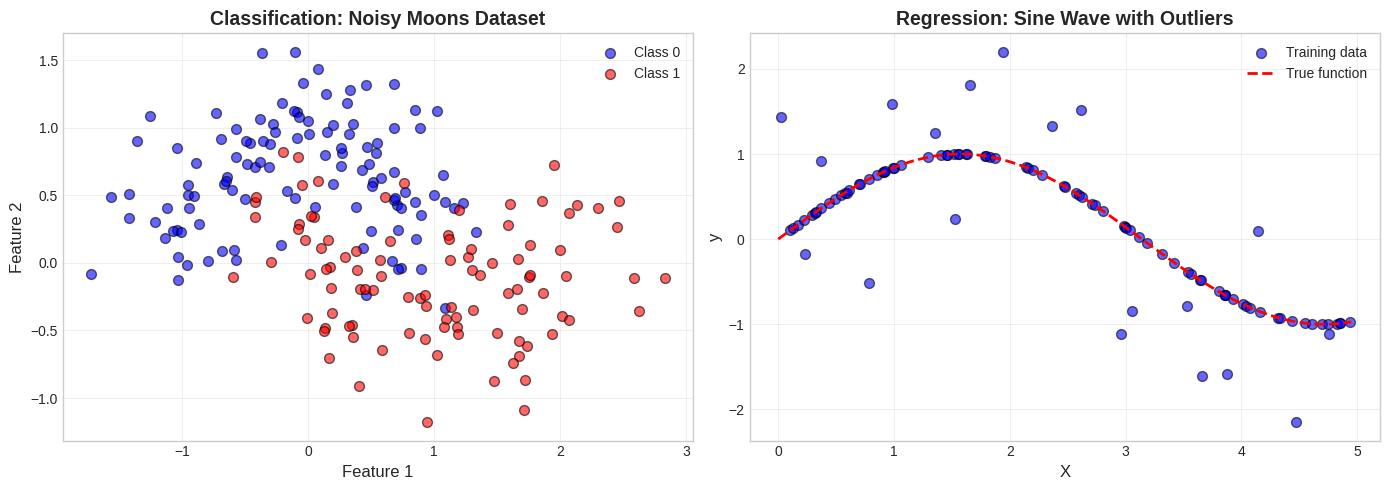

In [2]:
# Classification Data: Moons with high noise
X_cls, y_cls = make_moons(n_samples=300, noise=0.3, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=42
)

# Regression Data: Sine wave with noise spikes
np.random.seed(42)
X_reg = np.sort(5 * np.random.rand(100, 1), axis=0)
y_reg = np.sin(X_reg).ravel()
y_reg[::5] += 3 * (0.5 - np.random.rand(20))  # Add strong noise spikes
X_plot_reg = np.arange(0.0, 5.0, 0.05)[:, np.newaxis]

print(f"Classification data: {len(X_train_c)} train, {len(X_test_c)} test")
print(f"Regression data: {len(X_reg)} samples")
print("\nHigh noise added to demonstrate variance reduction.")

# Visualize data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classification data
axes[0].scatter(X_train_c[y_train_c==0, 0], X_train_c[y_train_c==0, 1],
               c='blue', label='Class 0', alpha=0.6, s=50, edgecolors='k')
axes[0].scatter(X_train_c[y_train_c==1, 0], X_train_c[y_train_c==1, 1],
               c='red', label='Class 1', alpha=0.6, s=50, edgecolors='k')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Classification: Noisy Moons Dataset', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regression data
axes[1].scatter(X_reg, y_reg, c='blue', alpha=0.6, s=50, edgecolors='k', label='Training data')
axes[1].plot(X_plot_reg, np.sin(X_plot_reg), 'r--', linewidth=2, label='True function')
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('Regression: Sine Wave with Outliers', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: The Problem - Single Tree Instability

Let's train multiple single trees and see how unstable they are.

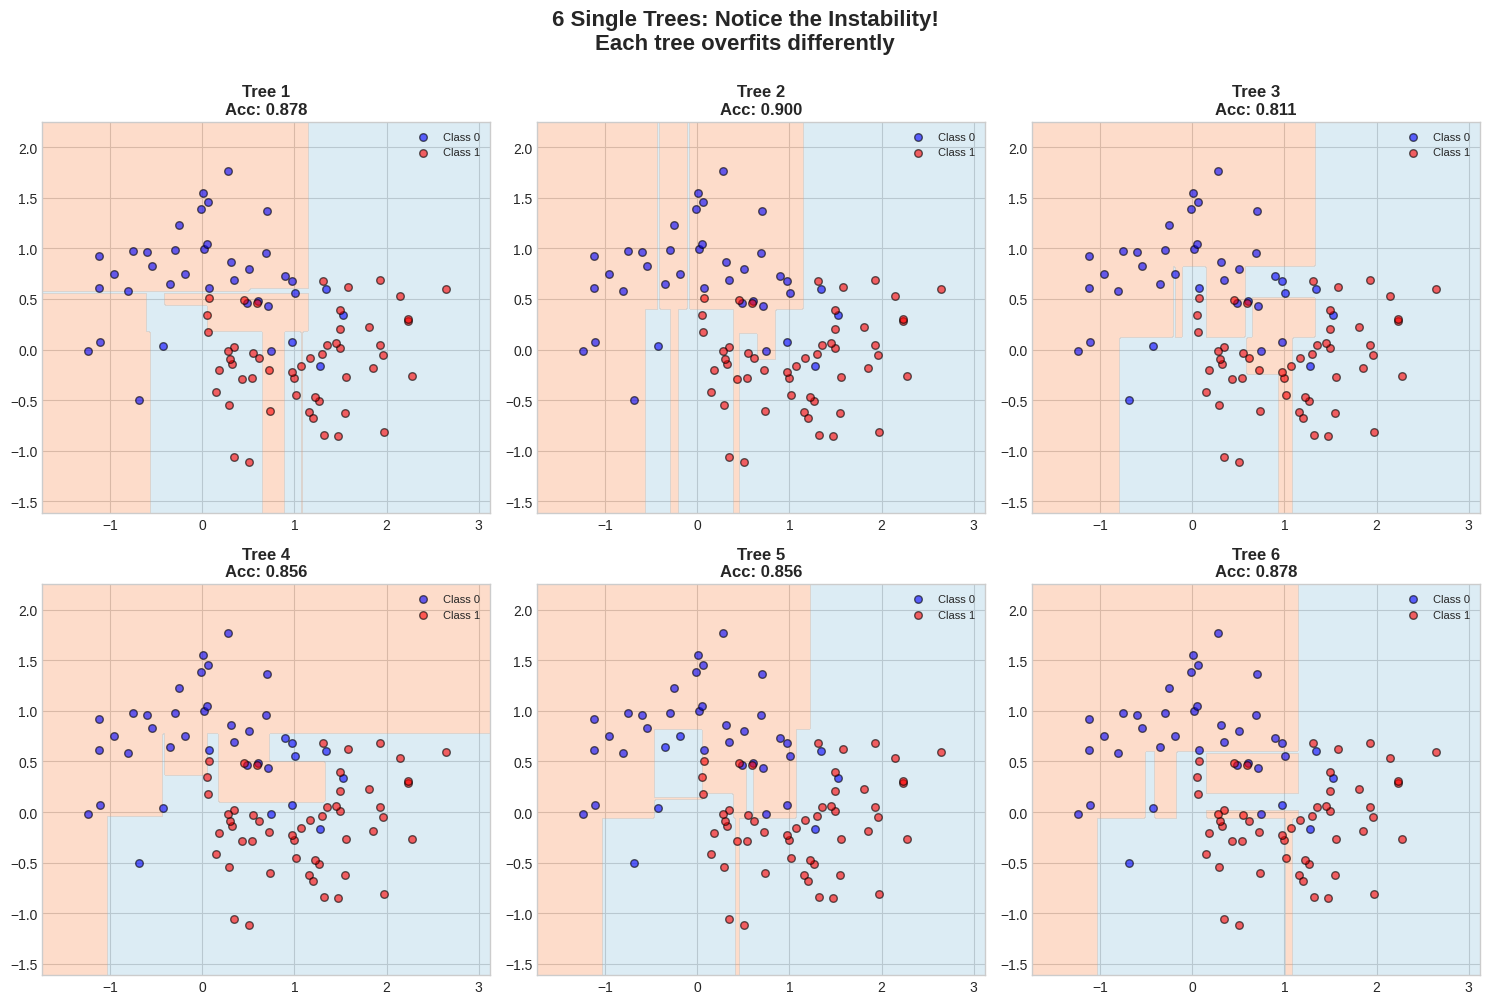


INSTABILITY ANALYSIS:
Accuracy range: 0.8111 to 0.9000
Accuracy std dev: 0.0277
Mean prediction variance: 0.0525

KEY OBSERVATION: Decision boundaries are very different!
This is HIGH VARIANCE - Bagging will fix this.


In [3]:
def plot_decision_boundary(model, X, y, title, ax):
    """Plot decision boundary for a classifier."""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', 
               label='Class 0', alpha=0.6, s=30, edgecolors='k')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', 
               label='Class 1', alpha=0.6, s=30, edgecolors='k')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

# Train 6 single trees on different bootstrap samples
np.random.seed(42)
n_trees = 6
single_trees = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in range(n_trees):
    # Create bootstrap sample
    indices = np.random.choice(len(X_train_c), size=len(X_train_c), replace=True)
    X_boot = X_train_c[indices]
    y_boot = y_train_c[indices]
    
    # Train tree
    tree = MyDecisionTreeClassifier(max_depth=8)
    tree.fit(X_boot, y_boot)
    single_trees.append(tree)
    
    # Plot
    acc = accuracy_score(y_test_c, tree.predict(X_test_c))
    plot_decision_boundary(tree, X_test_c, y_test_c,
                          f"Tree {i+1}\nAcc: {acc:.3f}",
                          axes[i])

plt.suptitle('6 Single Trees: Notice the Instability!\nEach tree overfits differently', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Calculate variance in predictions
all_preds = np.array([tree.predict(X_test_c) for tree in single_trees])
pred_variance = np.var(all_preds, axis=0)

print("\nINSTABILITY ANALYSIS:")
print("="*60)
accuracies = [accuracy_score(y_test_c, tree.predict(X_test_c)) for tree in single_trees]
print(f"Accuracy range: {min(accuracies):.4f} to {max(accuracies):.4f}")
print(f"Accuracy std dev: {np.std(accuracies):.4f}")
print(f"Mean prediction variance: {np.mean(pred_variance):.4f}")
print("\nKEY OBSERVATION: Decision boundaries are very different!")
print("This is HIGH VARIANCE - Bagging will fix this.")

## Part 3: Interactive Bagging Evolution

Watch how the ensemble improves as we add more trees.

In [4]:
def visualize_bagging_evolution(n_estimators):
    """Visualize how bagging ensemble improves with more trees."""
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Train bagging model
    bagging = GeneralBaggingClassifier(
        base_estimator=MyDecisionTreeClassifier(max_depth=8),
        n_estimators=n_estimators
    )
    bagging.fit(X_train_c, y_train_c)
    
    # Plot 1: Individual tree (first one)
    if len(bagging.estimators_) > 0:
        first_tree = bagging.estimators_[0]
        acc_single = accuracy_score(y_test_c, first_tree.predict(X_test_c))
        plot_decision_boundary(first_tree, X_test_c, y_test_c,
                              f"Single Tree\nAcc: {acc_single:.4f}",
                              axes[0])
    
    # Plot 2: Bagging ensemble
    acc_ensemble = accuracy_score(y_test_c, bagging.predict(X_test_c))
    plot_decision_boundary(bagging, X_test_c, y_test_c,
                          f"Bagging ({n_estimators} trees)\nAcc: {acc_ensemble:.4f}",
                          axes[1])
    
    # Plot 3: Performance comparison
    n_range = range(1, n_estimators + 1, max(1, n_estimators // 10))
    accuracies = []
    
    for n in n_range:
        bag_temp = GeneralBaggingClassifier(
            base_estimator=MyDecisionTreeClassifier(max_depth=8),
            n_estimators=n
        )
        bag_temp.fit(X_train_c, y_train_c)
        acc = accuracy_score(y_test_c, bag_temp.predict(X_test_c))
        accuracies.append(acc)
    
    axes[2].plot(n_range, accuracies, 'o-', linewidth=2, markersize=8, color='green')
    axes[2].axhline(y=acc_single, color='red', linestyle='--', 
                    linewidth=2, label='Single Tree')
    axes[2].axvline(x=n_estimators, color='blue', linestyle=':', 
                    linewidth=2, alpha=0.5, label='Current')
    axes[2].set_xlabel('Number of Trees', fontweight='bold', fontsize=12)
    axes[2].set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
    axes[2].set_title('Performance vs Ensemble Size', fontweight='bold', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    improvement = (acc_ensemble - acc_single) * 100
    print(f"\nCurrent configuration: {n_estimators} trees")
    print(f"Single tree accuracy: {acc_single:.4f}")
    print(f"Bagging accuracy: {acc_ensemble:.4f}")
    print(f"Improvement: {improvement:+.2f}%")
    print(f"\nBoundary is {'much' if n_estimators > 30 else 'somewhat'} smoother than single tree!")

# Create interactive widget
print("DRAG THE SLIDER to add more trees and watch the boundary stabilize:\n")
interact(visualize_bagging_evolution,
         n_estimators=IntSlider(min=1, max=100, step=5, value=10,
                               description='N Trees:', continuous_update=False));

DRAG THE SLIDER to add more trees and watch the boundary stabilize:



interactive(children=(IntSlider(value=10, continuous_update=False, description='N Trees:', min=1, step=5), Out…

## Part 4: Bootstrap Sampling Visualization

Let's see what bootstrap sampling actually does.

In [ ]:
def visualize_bootstrap_samples(sample_idx):
    """Visualize different bootstrap samples."""
    
    np.random.seed(sample_idx)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Original data
    axes[0].scatter(X_train_c[y_train_c==0, 0], X_train_c[y_train_c==0, 1],
                   c='blue', alpha=0.6, s=50, edgecolors='k', label='Class 0')
    axes[0].scatter(X_train_c[y_train_c==1, 0], X_train_c[y_train_c==1, 1],
                   c='red', alpha=0.6, s=50, edgecolors='k', label='Class 1')
    axes[0].set_title('Original Training Data\n(N samples)', fontweight='bold', fontsize=12)
    axes[0].legend()
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    
    # Generate 5 bootstrap samples
    for i in range(1, 6):
        indices = np.random.choice(len(X_train_c), size=len(X_train_c), replace=True)
        X_boot = X_train_c[indices]
        y_boot = y_train_c[indices]
        
        # Count unique samples
        unique_samples = len(np.unique(indices))
        
        axes[i].scatter(X_boot[y_boot==0, 0], X_boot[y_boot==0, 1],
                       c='blue', alpha=0.4, s=50, edgecolors='k', label='Class 0')
        axes[i].scatter(X_boot[y_boot==1, 0], X_boot[y_boot==1, 1],
                       c='red', alpha=0.4, s=50, edgecolors='k', label='Class 1')
        axes[i].set_title(f'Bootstrap Sample {i}\n({unique_samples}/{len(X_train_c)} unique)', 
                         fontweight='bold', fontsize=11)
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')
    
    plt.suptitle('Bootstrap Sampling: Each Tree Sees Different Data', 
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    print("\nBOOTSTRAP SAMPLING EXPLANATION:")
    print("="*60)
    print("- Sample WITH replacement from original training data")
    print("- Each bootstrap sample has same size as original")
    print("- Some samples appear multiple times, some not at all")
    print("- On average, ~63% of unique samples per bootstrap")
    print("- This creates diversity among trees")

# Create interactive widget
print("CHANGE SEED to see different bootstrap samples:\n")
interact(visualize_bootstrap_samples,
         sample_idx=IntSlider(min=0, max=20, step=1, value=0,
                             description='Random Seed:', continuous_update=False));

CHANGE SEED to see different bootstrap samples:



interactive(children=(IntSlider(value=0, continuous_update=False, description='Random Seed:', max=20), Output(…

## Part 5: Bagging for Regression

Let's see how bagging smooths predictions in regression problems.

In [ ]:
def visualize_regression_bagging(n_estimators):
    """Visualize bagging for regression problems."""
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Train single tree
    single_tree = MyDecisionTreeRegressor(max_depth=5)
    single_tree.fit(X_reg, y_reg)
    y_pred_single = single_tree.predict(X_plot_reg)
    mse_single = mean_squared_error(y_reg, single_tree.predict(X_reg))
    
    # Train bagging
    bagging = GeneralBaggingRegressor(
        base_estimator=MyDecisionTreeRegressor(max_depth=5),
        n_estimators=n_estimators
    )
    bagging.fit(X_reg, y_reg)
    y_pred_bagging = bagging.predict(X_plot_reg)
    mse_bagging = mean_squared_error(y_reg, bagging.predict(X_reg))
    
    # Plot 1: Single tree
    axes[0].scatter(X_reg, y_reg, c='blue', alpha=0.6, s=30, label='Training data')
    axes[0].plot(X_plot_reg, y_pred_single, 'g-', linewidth=2, label='Prediction')
    axes[0].plot(X_plot_reg, np.sin(X_plot_reg), 'r--', linewidth=2, label='True function')
    axes[0].set_title(f'Single Tree\nMSE: {mse_single:.4f}', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('y')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Bagging
    axes[1].scatter(X_reg, y_reg, c='blue', alpha=0.6, s=30, label='Training data')
    axes[1].plot(X_plot_reg, y_pred_bagging, 'g-', linewidth=2, label='Prediction')
    axes[1].plot(X_plot_reg, np.sin(X_plot_reg), 'r--', linewidth=2, label='True function')
    axes[1].set_title(f'Bagging ({n_estimators} trees)\nMSE: {mse_bagging:.4f}', 
                     fontweight='bold', fontsize=12)
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('y')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Show individual tree predictions
    axes[2].scatter(X_reg, y_reg, c='blue', alpha=0.3, s=20, label='Training data')
    
    # Plot first few individual tree predictions
    for i, tree in enumerate(bagging.estimators_[:min(10, n_estimators)]):
        y_pred_tree = tree.predict(X_plot_reg)
        axes[2].plot(X_plot_reg, y_pred_tree, alpha=0.2, linewidth=1, color='gray')
    
    axes[2].plot(X_plot_reg, y_pred_bagging, 'g-', linewidth=3, 
                label='Ensemble Average', zorder=10)
    axes[2].plot(X_plot_reg, np.sin(X_plot_reg), 'r--', linewidth=2, 
                label='True function', zorder=11)
    axes[2].set_title('Individual Trees (gray) vs Ensemble (green)', 
                     fontweight='bold', fontsize=12)
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('y')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    improvement = (mse_single - mse_bagging) / mse_single * 100
    print(f"\nCurrent configuration: {n_estimators} trees")
    print(f"Single tree MSE: {mse_single:.4f}")
    print(f"Bagging MSE: {mse_bagging:.4f}")
    print(f"MSE reduction: {improvement:.2f}%")
    print(f"\nNotice: Bagging {'significantly' if improvement > 20 else 'moderately'} smooths the prediction!")

# Create interactive widget
print("ADJUST NUMBER OF TREES to see smoothing effect:\n")
interact(visualize_regression_bagging,
         n_estimators=IntSlider(min=1, max=50, step=2, value=10,
                               description='N Trees:', continuous_update=False));

ADJUST NUMBER OF TREES to see smoothing effect:



interactive(children=(IntSlider(value=10, continuous_update=False, description='N Trees:', max=50, min=1, step…

## Part 6: Bias-Variance Decomposition

Mathematical proof that bagging reduces variance without increasing bias.

Running Monte Carlo Simulation (20 iterations)...

Trees    | Bias^2     | Variance   | Error     
--------------------------------------------------
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
Bagging: Đã huấn luyện xong 1 mô hình!
1        | 0.027454  | 0.377351  | 0.404805
Bagging: Đã huấn luyện xon

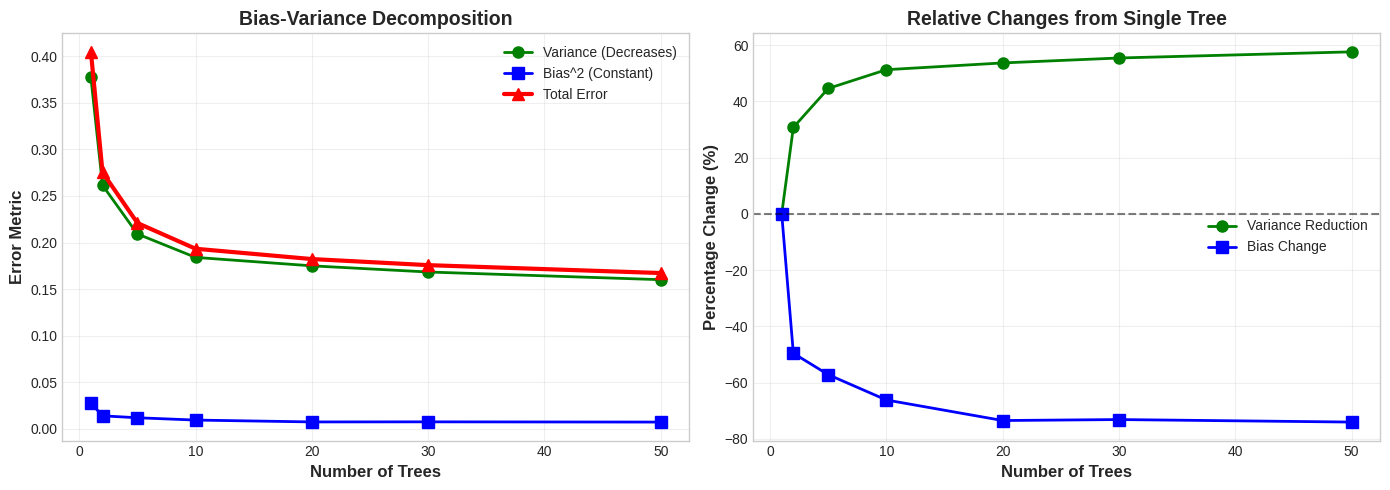


KEY FINDINGS:
Variance reduced by: 57.58%
Bias changed by: -74.03%
Total error reduced by: 58.70%

CONCLUSION: Bagging reduces VARIANCE without increasing BIAS!


In [7]:
# Prepare test data
X_plot_bv = np.arange(0.0, 5.0, 0.05)[:, np.newaxis]
y_true_bv = np.sin(X_plot_bv).ravel()

def simulate_bias_variance(n_tree_list, n_simulations=20):
    """Monte Carlo simulation to compute bias and variance."""
    biases, variances, errors = [], [], []
    
    print(f"Running Monte Carlo Simulation ({n_simulations} iterations)...\n")
    print(f"{'Trees':<8} | {'Bias^2':<10} | {'Variance':<10} | {'Error':<10}")
    print("-" * 50)
    
    for n_trees in n_tree_list:
        all_predictions = []
        
        for i in range(n_simulations):
            np.random.seed(i)
            # Generate random training data
            X_train_sim = np.sort(5 * np.random.rand(80, 1), axis=0)
            y_train_sim = np.sin(X_train_sim).ravel() + 3 * (0.5 - np.random.rand(80))
            
            # Train model
            model = GeneralBaggingRegressor(
                base_estimator=MyDecisionTreeRegressor(max_depth=4),
                n_estimators=n_trees
            )
            model.fit(X_train_sim, y_train_sim)
            
            # Predict
            preds = model.predict(X_plot_bv)
            all_predictions.append(preds)
        
        all_predictions = np.array(all_predictions)
        
        # Compute metrics
        main_prediction = np.mean(all_predictions, axis=0)
        bias_sq = np.mean((main_prediction - y_true_bv) ** 2)
        variance = np.mean(np.var(all_predictions, axis=0))
        total_error = bias_sq + variance
        
        print(f"{n_trees:<8} | {bias_sq:.6f}  | {variance:.6f}  | {total_error:.6f}")
        
        biases.append(bias_sq)
        variances.append(variance)
        errors.append(total_error)
    
    return biases, variances, errors

# Run simulation
n_trees_range = [1, 2, 5, 10, 20, 30, 50]
biases, variances, errors = simulate_bias_variance(n_trees_range)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All components
axes[0].plot(n_trees_range, variances, 'o-', color='green', 
            label='Variance (Decreases)', linewidth=2, markersize=8)
axes[0].plot(n_trees_range, biases, 's-', color='blue', 
            label='Bias^2 (Constant)', linewidth=2, markersize=8)
axes[0].plot(n_trees_range, errors, '^-', color='red', 
            label='Total Error', linewidth=3, markersize=8)
axes[0].set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Error Metric', fontsize=12, fontweight='bold')
axes[0].set_title('Bias-Variance Decomposition', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Relative to single tree
variance_reduction = [(variances[0] - v) / variances[0] * 100 for v in variances]
bias_change = [(b - biases[0]) / biases[0] * 100 for b in biases]

axes[1].plot(n_trees_range, variance_reduction, 'o-', color='green',
            label='Variance Reduction', linewidth=2, markersize=8)
axes[1].plot(n_trees_range, bias_change, 's-', color='blue',
            label='Bias Change', linewidth=2, markersize=8)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage Change (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Relative Changes from Single Tree', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("KEY FINDINGS:")
print("="*50)
print(f"Variance reduced by: {variance_reduction[-1]:.2f}%")
print(f"Bias changed by: {bias_change[-1]:.2f}%")
print(f"Total error reduced by: {(errors[0] - errors[-1])/errors[0]*100:.2f}%")
print("\nCONCLUSION: Bagging reduces VARIANCE without increasing BIAS!")

## Part 7: Performance Comparison Summary

Training final models for comprehensive comparison...

Bagging: Đã huấn luyện xong 5 mô hình!
Bagging: Đã huấn luyện xong 10 mô hình!
Bagging: Đã huấn luyện xong 25 mô hình!
Bagging: Đã huấn luyện xong 50 mô hình!
Bagging: Đã huấn luyện xong 100 mô hình!


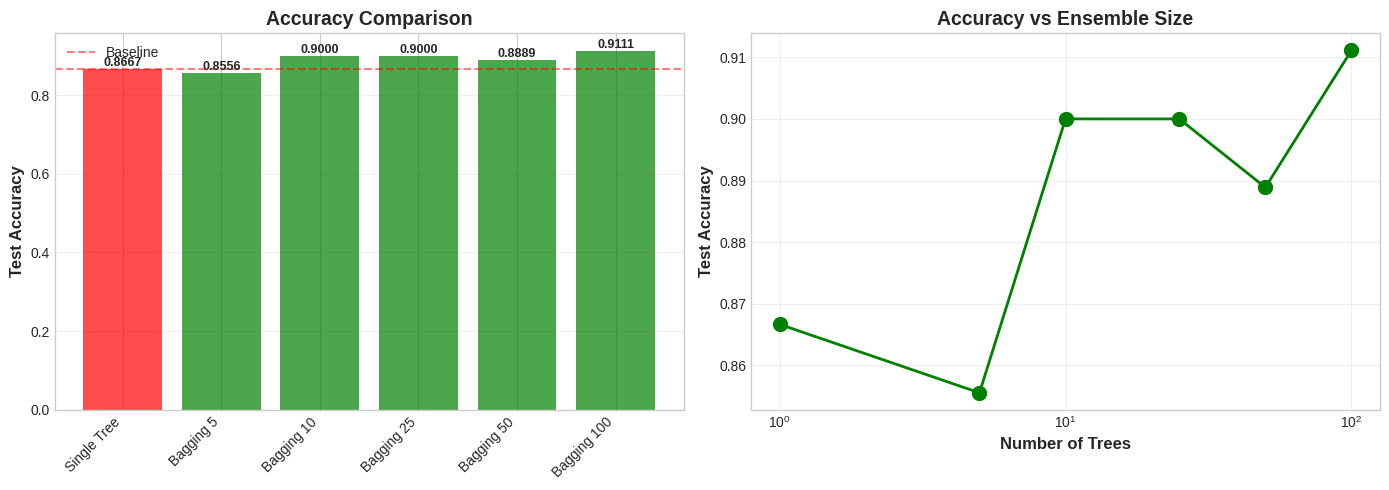


PERFORMANCE SUMMARY:
Model                Accuracy     Improvement    
------------------------------------------------------------
Single Tree          0.8667       +0.00%
Bagging 5            0.8556       -1.11%
Bagging 10           0.9000       +3.33%
Bagging 25           0.9000       +3.33%
Bagging 50           0.8889       +2.22%
Bagging 100          0.9111       +4.44%


In [8]:
# Train final models for comparison
print("Training final models for comprehensive comparison...\n")

# Single tree
single = MyDecisionTreeClassifier(max_depth=8)
single.fit(X_train_c, y_train_c)
acc_single = accuracy_score(y_test_c, single.predict(X_test_c))

# Bagging with different sizes
results = {'Single Tree': acc_single}
for n in [5, 10, 25, 50, 100]:
    bag = GeneralBaggingClassifier(
        base_estimator=MyDecisionTreeClassifier(max_depth=8),
        n_estimators=n
    )
    bag.fit(X_train_c, y_train_c)
    results[f'Bagging {n}'] = accuracy_score(y_test_c, bag.predict(X_test_c))

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
names = list(results.keys())
accs = list(results.values())
colors = ['red'] + ['green'] * (len(names) - 1)

bars = axes[0].bar(range(len(names)), accs, color=colors, alpha=0.7)
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
axes[0].axhline(y=acc_single, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend()

# Add value labels
for bar, acc in zip(bars, accs):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Line plot
n_trees = [1, 5, 10, 25, 50, 100]
bagging_accs = [acc_single] + [results[f'Bagging {n}'] for n in [5, 10, 25, 50, 100]]

axes[1].plot(n_trees, bagging_accs, 'o-', linewidth=2, markersize=10, color='green')
axes[1].set_xlabel('Number of Trees', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
axes[1].set_title('Accuracy vs Ensemble Size', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

# Print summary table
print("\nPERFORMANCE SUMMARY:")
print("="*60)
print(f"{'Model':<20} {'Accuracy':<12} {'Improvement':<15}")
print("-"*60)
for name, acc in results.items():
    improvement = (acc - acc_single) * 100
    print(f"{name:<20} {acc:.4f}       {improvement:+.2f}%")
print("="*60)

## Summary

1. **The Problem: Variance**
   - Single trees overfit and have unstable predictions
   - Small changes in data lead to very different models

2. **The Solution: Bootstrap + Aggregate**
   - Create diverse datasets via bootstrap sampling
   - Train independent models on each dataset
   - Average predictions to reduce variance

3. **Mathematical Guarantee**
   - Variance decreases as O(1/n) with n trees
   - Bias remains constant
   - Total error = Bias^2 + Variance decreases

4. **Practical Benefits**
   - Smoother decision boundaries
   - Better generalization
   - Parallel training (fast)
   - Low overfitting risk

### When to Use Bagging:

- High-variance models (deep decision trees)
- Unstable models sensitive to data changes
- Want to reduce overfitting
- Have computational resources for parallel training

### Random Forest = Bagging + Feature Randomness

Random Forest adds another layer of randomness by:
- Selecting random subset of features at each split
- Further decorrelates trees
- Even better variance reduction